# 20 Newsgroup Experiments
### This notebook contains the experiments for the 20 newsgroup data set
### For the results of the ablation experiment, refer to the notebook Ablation.ipynb.

In [152]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import sys
#
import torch.nn as nn

from time import time

import re

from sklearn.decomposition import NMF


from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer

import ssnmf
from ssnmf import SSNMF

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import guidedlda

import scipy.sparse as sparse

import math

### Function to covert list of keywords to topic vector

In [2]:
def d_to_v(d, verbose=True):
    """
    Given dictionary d of form {word: weight}, created seed topic vector v. See writeup for details.
    """
    l = list(idx_to_word)
    v = np.zeros(idx_to_word.shape[0])
    
    for key in d.keys():
        i = l.index(key)
        if(i < 0):
            print("Could not find word '" + key + "' in list of words!")
        else:
            v[i] = d[key]
            
    return v

In [105]:
def mat2data(documents_text):
    """
    Given a document data matrix X, convert it into a word list, 
    document index list, and word index list acceptable by the 
    SeededLDA code. 
    """
    
    documents_text = documents_text
    
    vectorizer = CountVectorizer(stop_words=stopwords_list)
    
    X_data = vectorizer.fit_transform(documents_text).transpose()
    
    X_data.toarray()
    
    word_list = vectorizer.get_feature_names()

    loc = sparse.find(X_data)
    
    i = loc[0][10]
    j = loc[1][10]
    
    word_ind_list = []
    doc_ind_list = []
    
    print(X_data.shape)
    
    for ind in range(len(loc[0])):
        
        word_ind = loc[0][ind]
        doc_ind = loc[1][ind]
        val = loc[2][ind]
        
        #for _ in range(val):
        word_ind_list.append(word_ind+1)
        doc_ind_list.append(doc_ind+1)

    word_list = np.asarray([str(x) for x in word_list])
    word_ind_list = np.asarray(word_ind_list)
    doc_ind_list = np.asarray(doc_ind_list)
    
    np.savetxt("word_list_flat.txt", word_list, fmt="%s")
    np.savetxt("word_ind_list_flat.txt", word_ind_list, fmt="%d")
    np.savetxt("doc_ind_list_flat.txt", doc_ind_list, fmt="%d")
    
    return X_data
            
    

In [132]:
for i in range(1890,1900):
    print(Y_cleaned[i])

tensor(4)
tensor(8)
tensor(4)
tensor(3)
tensor(9)
tensor(2)
tensor(7)
tensor(6)
tensor(3)
tensor(9)


## Preprocessing for 20 Newsgroup Data

In [130]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
 'comp.graphics',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'
 ]

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)

# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()
idx_to_word = np.array(vectorizer.get_feature_names())

X = vectors
d, n = np.shape(X)
#p = 7
Y = np.zeros((n))
#labels = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2, 6:2}
labels = {0:0, 1:0, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 9:5}

for i in range(n-1):
    label = newsgroups_train.target[i]
    Y[i] = label

X = torch.from_numpy(X.todense())
Y = torch.from_numpy(Y).long()


m = X.shape[0]
k1 = 10
k2 = 6

#X = X / torch.max(X)
# In[4]:
sub = 200 #HOW MANY PER CLASS
count = np.zeros((k1))

data_cleaned_new = []
Y_cleaned = []

X_new = torch.zeros((X.shape[0], sub*k1))
Y_new = torch.zeros((sub*k1)).long()
Y_10 = torch.zeros((sub*k1)).long()
j = 0
for i in range(Y.shape[0]):
    if(count[Y[i]] >= sub):
        continue
    count[Y[i]] += 1
    X_new[:,j] = X[:,i]
    Y_new[j] = labels[int(Y[i])]
    Y_10[j] = int(Y[i])
    j += 1
    
    data_cleaned_new.append(data_cleaned[i])
    Y_cleaned.append(Y[i])

X = X_new#
Y = Y_new

ind = np.argsort(Y_10)
X = X[:,ind]
Y = Y[ind]
Y_10 = Y_10[ind]

X = np.asarray(X)

mat2data(data_cleaned_new)

(27706, 2000)


<27706x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 125700 stored elements in Compressed Sparse Column format>

In [137]:
Y_cleaned = np.asarray(Y_cleaned)

In [139]:
np.save("newgroup_labels", Y_cleaned)

### Create Seed Topics and Y Matrix

In [107]:
baseball_words = {"pitch": 1}
medical_words = {"medical": 1}
space_words = {"space": 1}

gt_topic_words = [baseball_words, medical_words, space_words]
gt_topic_vectors = [d_to_v(x) for x in gt_topic_words]

Y = np.stack(gt_topic_vectors).T

motor_words = {"motorcycle": 1}
religion_words = {"religion": 1}
sale_words = {"sale": 1}

gt_topic_words_2  = [motor_words, religion_words, sale_words]
gt_topic_vectors_2 = [d_to_v(x) for x in gt_topic_words_2]

Y_2 = np.stack(gt_topic_vectors_2).T

## Experiment 1: Guided NMF with Baseball, Medical, and Space seed words

In [5]:
np.random.seed(1)
X = np.asarray(X)

model_1 = SSNMF(X.T,4,Y=Y.T,lam=20)
N=50
model_1.snmfmult(numiters = N)

S Matrix:


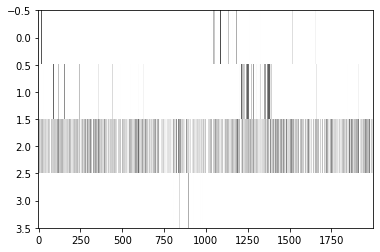

Topic 1     Topic 2  Topic 3  Topic 4    
-------     -------  -------  -------    
medical     space    people   pitch      
tests       nasa     know     expected   
disease     shuttle  think    curveball  
diseases    launch   time     stiffness  
prejudices  sci      use      loosen     
services    lunar    new      shoulder   
graduates   orbit    see      shea       
health      earth    say      rotation   
patients    station  us       game       
available   mission  god      giants     

For LaTeX table...
------------------------------
medical & space & people & pitch \\
tests & nasa & know & expected \\
disease & shuttle & think & curveball \\
diseases & launch & time & stiffness \\
prejudices & sci & use & loosen \\
services & lunar & new & shoulder \\
graduates & orbit & see & shea \\
health & earth & say & rotation \\
patients & station & us & game \\
available & mission & god & giants \\

Baseball topic accuracy...   0.8415916666666667
Medical topic accuracy...   0.75

In [6]:
S = model_1.A.T
A = model_1.S.T

#i = [1,0,2,3]
#A = A[:,i]
#S = S[i]

print("S Matrix:")
plt.imshow(S,aspect='auto',cmap='binary',interpolation='none')
plt.show()

keywords = np.empty((12,4), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(A.shape[1]):
    col = A[:,i]
    top = col.argsort()
    top = top[-10:][::-1]

    keywords[2:,i] = idx_to_word[top] 

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")
print("------------------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,4)]) + " \\\\")
    
print("")

topic_order = []
for i in range(model_1.B.shape[0]):
    topic_order.append(np.argmax(model_1.B[i]))

doc_orders = [4,5,6]

names = ["Baseball", "Medical", "Space"]

for i in range(len(topic_order)):
    y_pred = S[topic_order[i]]
    y_true = np.zeros(y_pred.shape[0])
    j = doc_orders[i]
    y_true[sub*j:sub*(j+1)] = 1
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    print(names[i], "topic accuracy...  ", auc(fpr,tpr))

## Experiment 2: Guided NMF with Motorcycle, Forsale, and Religion seed words

In [7]:
np.random.seed(1)

model_2 = SSNMF(X.T,4,Y=Y_2.T,lam=20)
N=50
model_2.snmfmult(numiters = N)

S Matrix:


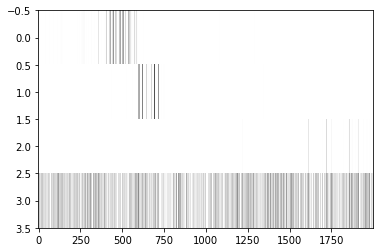

Topic 1    Topic 2     Topic 3     Topic 4  
-------    -------     -------     -------  
sale       motorcycle  religion    people   
offer      bike        christian   know     
condition  dod         judaism     think    
shipping   wheelie     freedom     time     
asking     shaft       christians  use      
includes   bikes       islam       new      
mb         rider       compulsion  space    
excellent  riding      avi         see      
price      scene       life        say      
best       ski         gunpoint    us       

For LaTeX table...
------------------------------
sale & motorcycle & religion & people \\
offer & bike & christian & know \\
condition & dod & judaism & think \\
shipping & wheelie & freedom & time \\
asking & shaft & christians & use \\
includes & bikes & islam & new \\
mb & rider & compulsion & space \\
excellent & riding & avi & see \\
price & scene & life & say \\
best & ski & gunpoint & us \\

Motorcycle topic accuracy...   0.8189111111111109
Religi

In [8]:
S = model_2.A.T
A = model_2.S.T

#i = [1,0,2,3]
#A = A[:,i]
#S = S[i]

print("S Matrix:")
plt.imshow(S,aspect='auto',cmap='binary',interpolation='none')
plt.show()

keywords = np.empty((12,4), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(A.shape[1]):
    col = A[:,i]
    top = col.argsort()
    top = top[-10:][::-1]

    keywords[2:,i] = idx_to_word[top] 

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))

print("")
print("For LaTeX table...")
print("------------------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for i, row in enumerate(keywords):
    if(i >= 2):
        print(" & ".join([row[i] for i in range(0,4)]) + " \\\\")
    
print("")

topic_order = []
for i in range(model_2.B.shape[0]):
    topic_order.append(np.argmax(model_2.B[i]))

doc_orders = [3,9,2]

names = ["Motorcycle", "Religion", "For Sale"]

for i in range(len(topic_order)):
    y_pred = S[topic_order[i]]
    y_true = np.zeros(y_pred.shape[0])
    j = doc_orders[i]
    y_true[sub*j:sub*(j+1)] = 1
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    print(names[i], "topic accuracy...  ", auc(fpr,tpr))

### Ablation Experiment
Here we run GuidedNMF on a variety of ranks and numbers of seed words. We explore these results and compare to SeededLDA in the notebook **Ablation.ipynb**.

In [ ]:
baseball_words = ["pitch", "baseball", "team", "ball", "game", "season", "base", "field", "runs"]
medical_words = ["medical", "disease", "doctor", "health", "patient", "medicine", "clinic", "diet", "tests"]
space_words = ["space", "lunar", "nasa", "launch", "rocket", "moon", "shuttle", "orbit", "solar"]

models = []
for r in range(4,11):
    
    models.append([])
    
    print("")
    print("Starting rank... ", r)
    print("----------------")
    
    for i in range(1,9):

        print("Starting seeds... ", i)
        
        baseball_words_dict = {word:1 for word in baseball_words[:i]}
        medical_words_dict = {word:1 for word in medical_words[:i]}
        space_words_dict = {word:1 for word in space_words[:i]}

        gt_topic_words = [baseball_words_dict, medical_words_dict, space_words_dict]
        gt_topic_vectors= [d_to_v(x) for x in gt_topic_words]

        Y = np.stack(gt_topic_vectors).T
        
        model = SSNMF(X.T,r,Y=Y.T,lam = 320 / i / r**2)
        N=50
        model.snmfmult(numiters = N)

        models[-1].append(model)
        np.save("guidednmf_models", models)


Starting rank...  4
----------------
Starting seeds...  1
Starting seeds...  2
Starting seeds...  3
Starting seeds...  4
Starting seeds...  5
Starting seeds...  6
Starting seeds...  7
Starting seeds...  8

Starting rank...  5
----------------
Starting seeds...  1


/home/jvendrow/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Starting seeds...  2
Starting seeds...  3
Starting seeds...  4
Starting seeds...  5
Starting seeds...  6
Starting seeds...  7
Starting seeds...  8

Starting rank...  6
----------------
Starting seeds...  1
Starting seeds...  2
Starting seeds...  3
Starting seeds...  4
Starting seeds...  5
Starting seeds...  6
Starting seeds...  7
Starting seeds...  8

Starting rank...  7
----------------
Starting seeds...  1
Starting seeds...  2
Starting seeds...  3
Starting seeds...  4
Starting seeds...  5
Starting seeds...  6
Starting seeds...  7
Starting seeds...  8

Starting rank...  8
----------------
Starting seeds...  1
Starting seeds...  2
Starting seeds...  3
Starting seeds...  4
Starting seeds...  5
Starting seeds...  6
